In [570]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Data Preparation

In [571]:
df = pd.read_excel('Online Retail.xlsx')
df = df.replace(to_replace="Israel", value="Palestine")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [572]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [573]:
df.notnull().sum()

InvoiceNo      541909
StockCode      541909
Description    540455
Quantity       541909
InvoiceDate    541909
UnitPrice      541909
CustomerID     406829
Country        541909
dtype: int64

In [574]:
id = 1
for i in range(len(df)):
    if np.isnan(df.iloc[i, 6]):
        df.iloc[i, 6] = id
        if df.iloc[i, 0] != df.iloc[i+1, 0]:
            id += 1

In [575]:
df.notnull().sum()

InvoiceNo      541909
StockCode      541909
Description    540455
Quantity       541909
InvoiceDate    541909
UnitPrice      541909
CustomerID     541909
Country        541909
dtype: int64

# Feature Engineering

In [576]:
def customer_shopping_report(df, id):
    customer_df = df[(df['CustomerID']==id) & (df['Quantity']>0)]
    
    if customer_df.empty:
        return False
    
    total_spend = 0
    for index, row in customer_df.iterrows():
        total_spend += row['UnitPrice'] * row['Quantity']
        
    freq_order = len(customer_df['InvoiceNo'].unique())
    avg_basket_size = sum(customer_df['Quantity']) / freq_order
    country = customer_df['Country'].iloc[0]
    
    return [id, total_spend, avg_basket_size, freq_order, country]

In [577]:
seg_df = pd.DataFrame(columns=['ID', 'TotalSpend', 'AvgBasketSize', 'FreqOrder', 'Country'])

customer_id_unique = df['CustomerID'].unique()
for id in customer_id_unique:
    if customer_shopping_report(df, id) != False:
        seg_df.loc[len(seg_df)] = customer_shopping_report(df, id)
    
seg_df.head()

,ID,TotalSpend,AvgBasketSize,FreqOrder,Country
0,17850.0,5391.21,50.970588,34,United Kingdom
1,13047.0,3237.54,139.100000,10,United Kingdom
2,12583.0,7281.38,337.333333,15,France
3,13748.0,948.25,87.800000,5,United Kingdom
4,15100.0,876.00,26.666667,3,United Kingdom


In [578]:
seg_df.describe()

,ID,TotalSpend,AvgBasketSize,FreqOrder
count,6531.000000,6531.000000,6531.000000,6531.000000
mean,10780.751493,1629.851542,243.673408,3.173787
std,6542.180743,7467.716324,1135.537221,6.467705
min,1.000000,-11062.060000,1.000000,1.000000
25%,2723.000000,130.245000,49.000000,1.000000
50%,13801.000000,501.120000,131.000000,1.000000
75%,16032.000000,1456.875000,269.305556,3.000000
max,18287.000000,280206.020000,74215.000000,210.000000


In [579]:
def remove_outliers(df, col_name):
    percentile25 = df[col_name].quantile(0.25)
    percentile75 = df[col_name].quantile(0.75)
    
    iqr = percentile75 - percentile25
    
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    
    return df[(df[col_name]<upper_limit) & (df[col_name]>lower_limit)]

<AxesSubplot:ylabel='FreqOrder'>

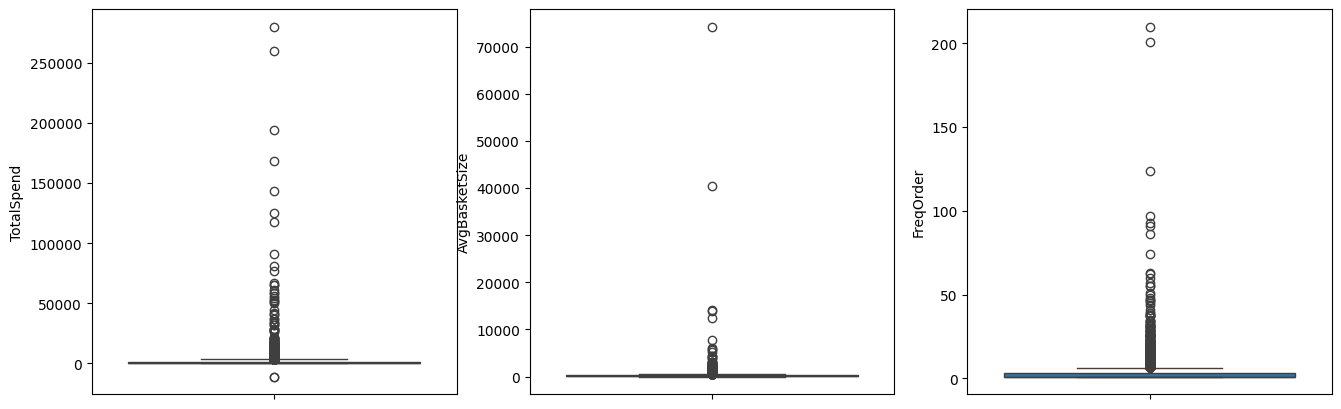

In [580]:
_, axes = plt.subplots(ncols=3, figsize=(16,5))
sns.boxplot(seg_df['TotalSpend'], ax=axes[0])
sns.boxplot(seg_df['AvgBasketSize'], ax=axes[1])
sns.boxplot(seg_df['FreqOrder'], ax=axes[2])

In [581]:
seg_df = remove_outliers(seg_df, 'TotalSpend')
seg_df = remove_outliers(seg_df, 'AvgBasketSize')
seg_df = remove_outliers(seg_df, 'FreqOrder')

<AxesSubplot:ylabel='FreqOrder'>

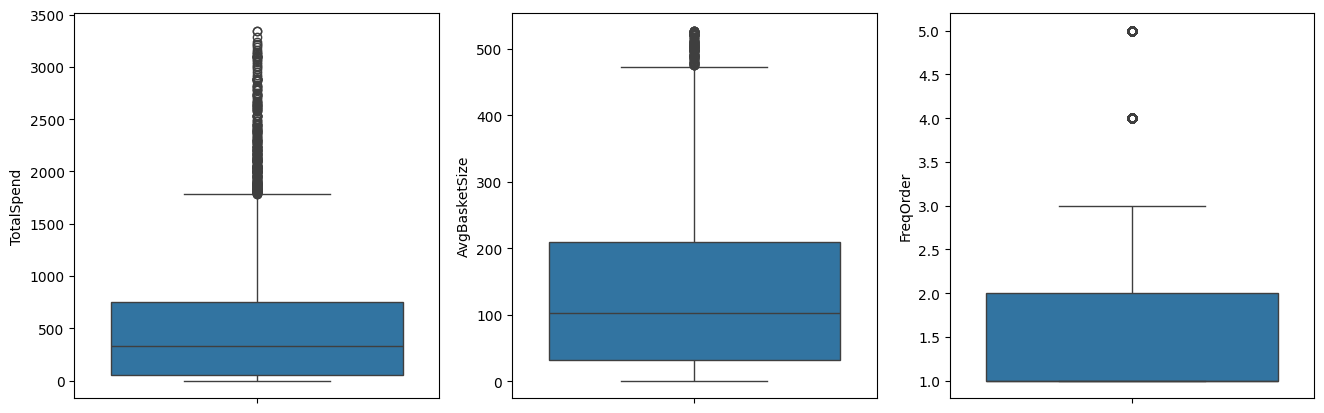

In [582]:
_, axes = plt.subplots(ncols=3, figsize=(16,5))
sns.boxplot(seg_df['TotalSpend'], ax=axes[0])
sns.boxplot(seg_df['AvgBasketSize'], ax=axes[1])
sns.boxplot(seg_df['FreqOrder'], ax=axes[2])

In [583]:
nseg_df = seg_df.reset_index()
nseg_df

,index,ID,TotalSpend,AvgBasketSize,FreqOrder,Country
0,3,13748.0,948.25,87.800000,5,United Kingdom
1,4,15100.0,876.00,26.666667,3,United Kingdom
2,11,18074.0,489.60,190.000000,1,United Kingdom
3,12,17420.0,598.83,88.333333,3,United Kingdom
4,14,16250.0,389.44,104.000000,2,United Kingdom
...,...,...,...,...,...,...
5151,6522,3703.0,0.00,20.000000,1,United Kingdom
5152,6523,14569.0,227.39,79.000000,1,United Kingdom
5153,6524,3705.0,17.90,14.000000,1,United Kingdom
5154,6525,3706.0,3.35,2.000000,1,United Kingdom


# Dimensionality Reduction with PCA

In [584]:
x = nseg_df.drop(columns=['index', 'ID', 'FreqOrder', 'Country'], axis=1)
y = nseg_df['ID']
x_scl = StandardScaler().fit_transform(x)

In [585]:
y

0       13748.0
1       15100.0
2       18074.0
3       17420.0
4       16250.0
         ...   
5151     3703.0
5152    14569.0
5153     3705.0
5154     3706.0
5155    12713.0
Name: ID, Length: 5156, dtype: float64

In [586]:
x

,TotalSpend,AvgBasketSize
0,948.25,87.800000
1,876.00,26.666667
2,489.60,190.000000
3,598.83,88.333333
4,389.44,104.000000
...,...,...
5151,0.00,20.000000
5152,227.39,79.000000
5153,17.90,14.000000
5154,3.35,2.000000


In [587]:
dim_red = PCA()
x_pca = dim_red.fit_transform(x_scl)
dim_red.explained_variance_ratio_

array([0.84339125, 0.15660875])

In [588]:
dim_red.get_feature_names_out()

array(['pca0', 'pca1'], dtype=object)

In [589]:
df_pca = pd.DataFrame(x_pca, columns=dim_red.get_feature_names_out())
df_pca

,pca0,pca1
0,0.210656,-0.766201
1,-0.212027,-1.020461
2,0.241916,0.334221
3,-0.193659,-0.355980
4,-0.350974,-0.025185
...,...,...
5151,-1.269962,-0.036347
5152,-0.678267,0.025278
5153,-1.282319,-0.090430
5154,-1.365717,-0.139910


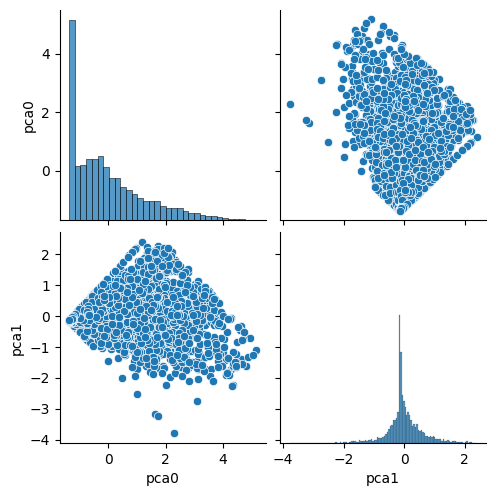

In [590]:
sns.pairplot(df_pca)

<AxesSubplot:ylabel='pca1'>

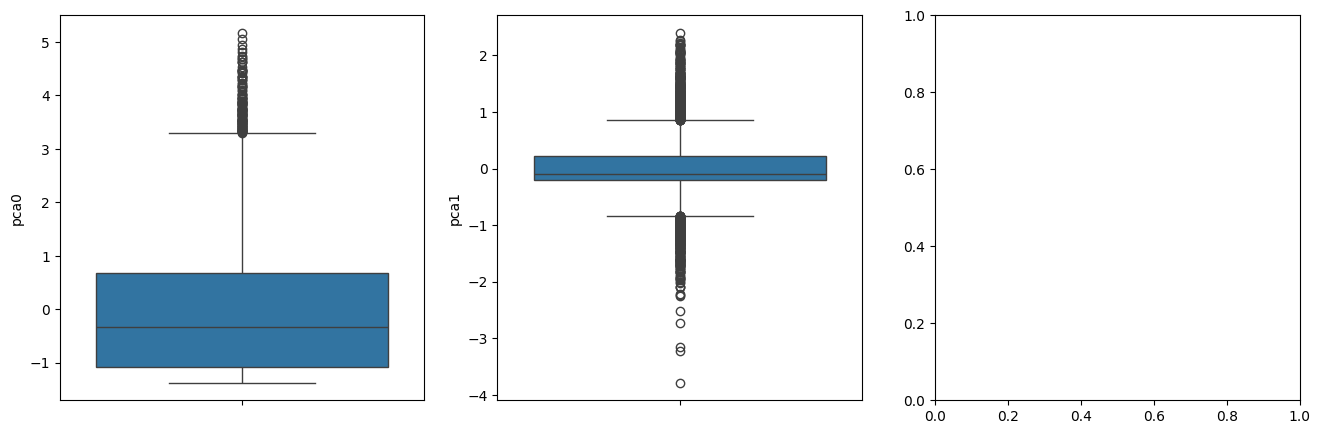

In [591]:
_, axes = plt.subplots(ncols=3, figsize=(16,5))
sns.boxplot(df_pca['pca0'], ax=axes[0])
sns.boxplot(df_pca['pca1'], ax=axes[1])
#sns.boxplot(df_pca['pca2'], ax=axes[2])

In [592]:
df_pca['ID'] = y

df_pca = remove_outliers(df_pca, 'pca0')
df_pca = remove_outliers(df_pca, 'pca1')
#df_pca = remove_outliers(df_pca, 'pca2')

df_pca = pd.DataFrame(df_pca.to_numpy(), columns=['pca0', 'pca1', 'ID'])

y_pca = df_pca['ID']
df_pca = df_pca.drop(columns=['ID'], axis=1)

df_pca

,pca0,pca1
0,0.210656,-0.766201
1,0.241916,0.334221
2,-0.193659,-0.355980
3,-0.350974,-0.025185
4,-0.939170,0.053643
...,...,...
4421,-0.429581,-0.035164
4422,-1.269962,-0.036347
4423,-0.678267,0.025278
4424,-1.282319,-0.090430


In [593]:
y_pca

0       13748.0
1       18074.0
2       17420.0
3       16250.0
4       17548.0
         ...   
4421    13298.0
4422     3703.0
4423    14569.0
4424     3705.0
4425     3706.0
Name: ID, Length: 4426, dtype: float64

<AxesSubplot:ylabel='pca1'>

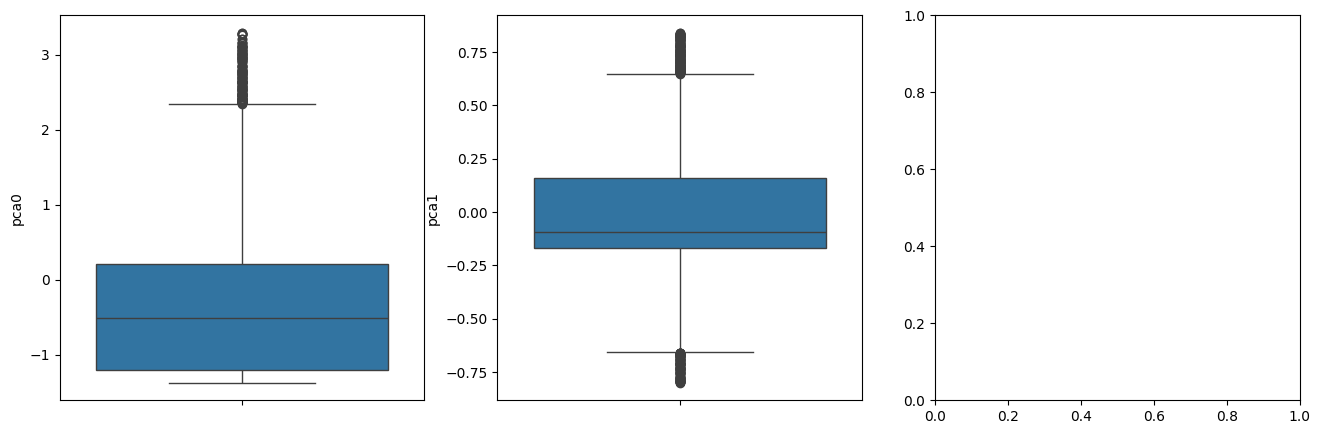

In [594]:
_, axes = plt.subplots(ncols=3, figsize=(16,5))
sns.boxplot(df_pca['pca0'], ax=axes[0])
sns.boxplot(df_pca['pca1'], ax=axes[1])
#sns.boxplot(df_pca['pca2'], ax=axes[2])

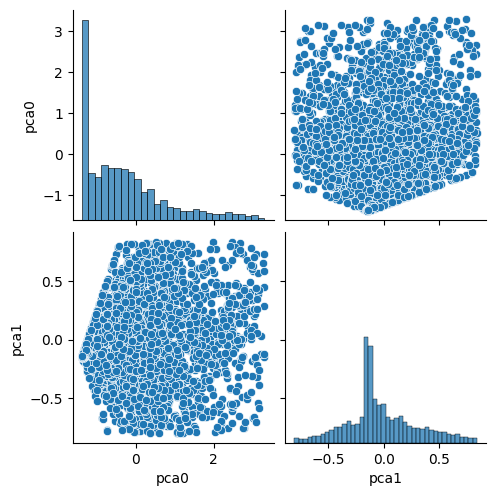

In [595]:
sns.pairplot(df_pca)

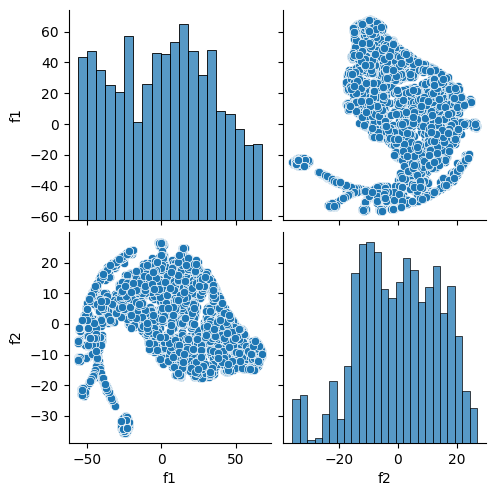

In [596]:
dim_tsne = TSNE(perplexity=80)
x_tsne = dim_tsne.fit_transform(df_pca.to_numpy())
df_tsne = pd.DataFrame(x_tsne, columns=['f1','f2'])
sns.pairplot(df_tsne)

In [620]:
df_test = df_tsne
df_test

,f1,f2
0,23.209814,-17.221199
1,30.887030,4.486182
2,10.266152,-9.776057
3,7.734016,4.310847
4,-16.261995,15.045713
...,...,...
4421,4.661175,5.033101
4422,-39.263000,16.389437
4423,-4.952975,11.355196
4424,-40.804493,7.604398


# Determining Optimal Number of Clusters

In [621]:
list_of_inirtias = []
for n in range(1,20):
    km = KMeans(n_clusters=n)
    km.fit(df_test)
    list_of_inirtias.append(km.inertia_)
    print(n, km.inertia_)

1 5781311.0
2 2177176.0
3 1316449.125
4 980303.0
5 796018.375
6 614188.6875
7 502366.34375
8 412301.78125
9 360770.15625
10 322679.625
11 276189.0
12 249608.109375
13 228123.015625
14 210181.21875
15 193721.5
16 177993.28125
17 164542.484375
18 154078.203125
19 144979.765625


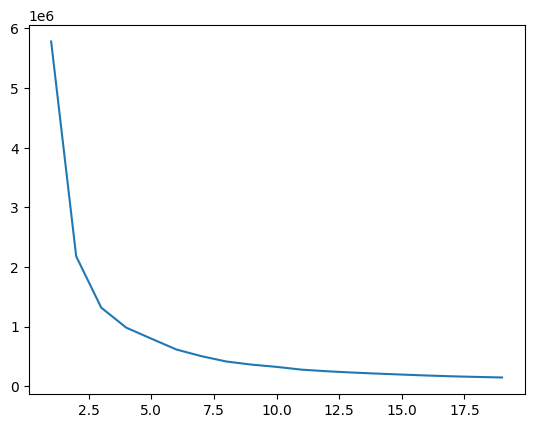

In [622]:
plt.plot(range(1,20), list_of_inirtias)

# K-means Clustering

In [623]:
agg = AgglomerativeClustering(n_clusters=2)
predictions = agg.fit_predict(df_test)

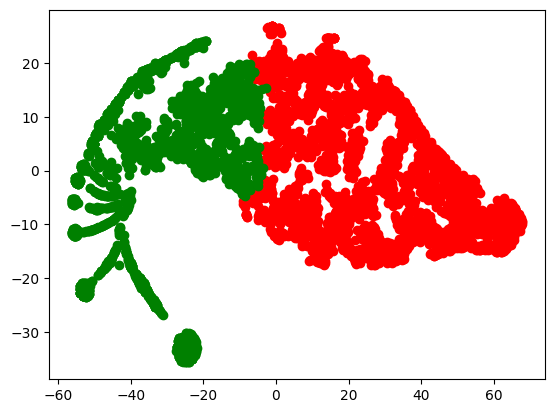

In [624]:
plt.scatter(df_test.iloc[predictions==0,0], df_test.iloc[predictions==0,1], color='red')
plt.scatter(df_test.iloc[predictions==1,0], df_test.iloc[predictions==1,1], color='green')

#  Cluster Profiling

In [625]:
df_test['ID'] = y_pca
df_test

,f1,f2,ID
0,23.209814,-17.221199,13748.0
1,30.887030,4.486182,18074.0
2,10.266152,-9.776057,17420.0
3,7.734016,4.310847,16250.0
4,-16.261995,15.045713,17548.0
...,...,...,...
4421,4.661175,5.033101,13298.0
4422,-39.263000,16.389437,3703.0
4423,-4.952975,11.355196,14569.0
4424,-40.804493,7.604398,3705.0


In [626]:
id_0 = df_test.iloc[predictions==0,2]
id_0

0       13748.0
1       18074.0
2       17420.0
3       16250.0
5       13705.0
         ...   
4407    12442.0
4409    16569.0
4412    14204.0
4413    15471.0
4421    13298.0
Name: ID, Length: 2548, dtype: float64

In [627]:
id_1 =  df_test.iloc[predictions==1,2]
id_1

4       17548.0
6       13747.0
10          1.0
23      17572.0
26      14237.0
         ...   
4420     3699.0
4422     3703.0
4423    14569.0
4424     3705.0
4425     3706.0
Name: ID, Length: 1878, dtype: float64

In [628]:
df_0 = nseg_df[(nseg_df['ID'].isin(id_0))].drop(columns=['index', 'ID'], axis=1)
df_0

,TotalSpend,AvgBasketSize,FreqOrder,Country
0,948.25,87.800000,5,United Kingdom
2,489.60,190.000000,1,United Kingdom
3,598.83,88.333333,3,United Kingdom
4,389.44,104.000000,2,United Kingdom
6,711.86,121.000000,3,United Kingdom
...,...,...,...,...
5132,172.06,182.000000,1,Spain
5134,124.20,93.000000,1,United Kingdom
5140,161.03,82.000000,1,United Kingdom
5141,469.48,266.000000,1,United Kingdom


In [629]:
df_1 = nseg_df[(nseg_df['ID'].isin(id_1))].drop(columns=['index', 'ID'], axis=1)
df_1

,TotalSpend,AvgBasketSize,FreqOrder,Country
5,103.30,58.00,1,United Kingdom
7,79.60,8.00,1,United Kingdom
12,0.00,56.00,1,United Kingdom
25,226.75,23.75,4,United Kingdom
28,161.00,38.00,1,United Kingdom
...,...,...,...,...
5148,0.00,27.00,1,United Kingdom
5151,0.00,20.00,1,United Kingdom
5152,227.39,79.00,1,United Kingdom
5153,17.90,14.00,1,United Kingdom


In [630]:
df_0.describe()

,TotalSpend,AvgBasketSize,FreqOrder
count,2548.000000,2548.000000,2548.000000
mean,677.004452,174.508222,1.977237
std,447.821430,94.518860,1.166318
min,0.000000,1.000000,1.000000
25%,336.105000,102.000000,1.000000
50%,570.710000,148.000000,2.000000
75%,934.610000,225.000000,3.000000
max,2157.400000,502.000000,5.000000


In [631]:
df_1.describe()

,TotalSpend,AvgBasketSize,FreqOrder
count,1878.000000,1878.000000,1878.000000
mean,66.868419,23.764457,1.134185
std,93.650659,24.179172,0.448870
min,0.000000,1.000000,1.000000
25%,0.000000,3.000000,1.000000
50%,11.665000,13.000000,1.000000
75%,114.590000,42.000000,1.000000
max,379.650000,87.000000,5.000000


# Visualization

Text(0, 0.5, 'Avg Basket Size')

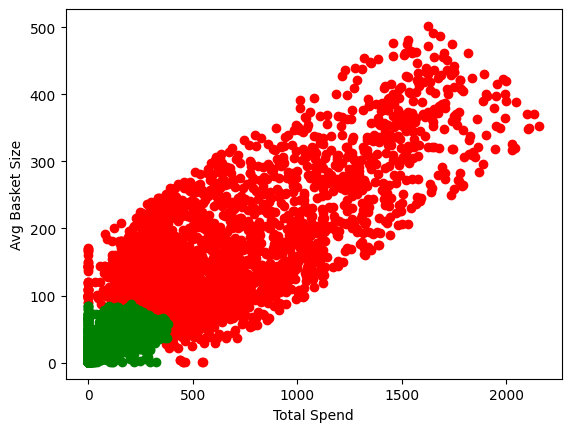

In [632]:
plt.scatter(df_0.loc[:,'TotalSpend'], df_0.loc[:,'AvgBasketSize'], color='red')
plt.scatter(df_1.loc[:,'TotalSpend'], df_1.loc[:,'AvgBasketSize'], color='green')
plt.xlabel("Total Spend")
plt.ylabel("Avg Basket Size")

# Evaluation

In [633]:
ss = silhouette_score(df_test, agg.labels_) 
print(ss)

0.2858201880535822


# Personalization and Recommendations

1. **Demographic Segments**:
   - **Young Professionals (Age 25-34)**:
     - Leverage social media (Instagram, TikTok).
     - Promote tech gadgets, fashion, and events.
     - Use chatbots and casual email language.
   - **Seniors (Age 55+)**:
     - Use direct mail, TV ads, and phone calls.
     - Highlight ease of use, offer senior discounts.
     - Personalized phone updates, mailed catalogs.

2. **Behavioral Segments**:
   - **Frequent Shoppers**:
     - Retargeting ads, SMS notifications.
     - Loyalty programs, cross-selling.
     - Regular email updates, thank-you messages.
   - **One-Time Buyers**:
     - Email reminders, display ads.
     - Incentives for repeat purchases, showcase products.
     - Abandoned cart reminders, limited-time offers.

3. **Psychographic Segments**:
   - **Eco-Conscious Consumers**:
     - Social media campaigns, eco-friendly products.
     - Share environmental impact stories.
     - Eco-friendly packaging messages.
   - **Adventure Seekers**:
     - Instagram, YouTube, outdoor gear.
     - Create travel-themed bundles.
     - Adventure-themed newsletters.

4. **Geographic Segments**:
   - **Urban Dwellers**:
     - Geotargeted ads, urban fashion.
     - Same-day shipping, city-specific promotions.
   - **Suburban Families**:
     - Community events, family-friendly products.
     - Parenting tips via email, back-to-school promos.

# Interpretation and Insights

1. **Segmentation Interpretation**:
   - Segmentation divides customers based on characteristics, age, gender, education or behaviors.

2. **E-Commerce Implications**:
   - **Targeted Marketing**:
     - Personalize ads and channels.
     - Use loyalty programs and seasonal offers.
   - **Customer Retention**:
     - Predict churn, tailor loyalty programs.
     - Gather feedback, reactivate inactive customers.
   - **Inventory Management**:
     - Forecast demand, optimize assortment.
     - Prioritize stock rotation.

3. **Data-Driven Decisions**:
   - Continuously analyze data for better results.